# 4 Using LLMs as Judges

Previous sections in this lab all focus on easy to evaluate outputs: single word, multiple choice, true/false etc.  The evaluation of longer text (summary) only uses NLP metrics which might not be too related to its semantics.  In order to better understand the semantics, and other "quality" of the answer, we can use a (more powerful) LLM as a judge. 

In this subsection, we'll explore how to use LLMs as judges to evaluate model outputs. This approach leverages the capabilities of large language models to assess the quality of responses from other models, providing a flexible evaluation method that can be applied across various tasks. And llm-as-judge is also a well-used method in industry and LLM research field now. For more detailed knowledge, I recommand you to read this survey: https://arxiv.org/pdf/2411.15594?

Here, we provide a simplified process and discusses several common challenges to llm-as-judge.

## 4.1 Setting up

We use the same task as 01_evaluation, i.e., CNN_DAILYMAIL here.

In [2]:
#Setting up the environment
#Continue to use OpenAI API and INFINI Platform
from dotenv import load_dotenv
import os
import threading
from openai import OpenAI
import time
import random
from openai import RateLimitError


In [3]:
# we use API in this section
load_dotenv()
openai_api_key = os.environ.get("INFINI_API_KEY")
openai_base_url = os.environ.get("INFINI_BASE_URL")
client = OpenAI(api_key=openai_api_key, base_url=openai_base_url)

In [4]:
# these are just duplicates from section 2.  You can skip them if you have already read section 2.

def get_llm_output(model_name, question_content, question_id, output, semaphore=None):
    try:
        retries = 5
        for attempt in range(retries):
            try:
                if isinstance(question_content, str):
                    messages = [{"role": "user", "content": question_content}]
                else:
                    messages = [{"role": "user", "content": q} for q in question_content]

                chat_response = client.chat.completions.create(
                    model=model_name,
                    messages=messages,
                    max_tokens=2048,
                    temperature=0,
                )

                llm_answer = chat_response.choices[0].message.content.strip()
                output[question_id] = llm_answer
                break  # 成功就退出 retry 循环

            except RateLimitError as e:
                wait_time = random.uniform(1, 3) * (2 ** attempt)
                print(f"RateLimitError on Q{question_id}, retry {attempt+1}/{retries}, wait {wait_time:.1f}s")
                time.sleep(wait_time)

            except Exception as e:
                print(f"Error on Q{question_id}: {e}")
                break 

        else:
            output[question_id] = ""

    finally:
        if semaphore:
            semaphore.release()

def get_llm_output_parallel(model_name, question_contents, max_threads=5):
    # Create threads for each question
    output = {}
    threads = []
    semaphore = threading.Semaphore(max_threads)
    for question_id, question_content in tqdm(enumerate(question_contents)):
        semaphore.acquire() 
        thread = threading.Thread(target=get_llm_output, args=(model_name, question_content, question_id, output, semaphore))
        threads.append(thread)
        thread.start()

    # Wait for all threads to complete
    for thread in threads:
        thread.join()

    sorted_keys = sorted(output.keys())
    sorted_outputs = [output[key] for key in sorted_keys]        
    return sorted_outputs


Now let's load the dataset.  The dataset is described as

1. Source:
- Created from articles published on CNN and Daily Mail websites
- Articles were collected between 2007 and 2015
2. Each example consists of:
- A news article (document)
- Bullet point highlights/summaries of the article
- The highlights are treated as reference summaries

The dataset is popular in evaluating summarization tasks. 

In [5]:
from datasets import load_dataset, load_from_disk

d = load_from_disk('/ssdshare/share/data/cnn_dailymail/')

In [6]:
def create_prompt(x):
    s = "Please summarize the following news article in no more than 30 words.\n %s" %(x['article'])
    x['question_content'] = s
    return x

d = d['test'].map(create_prompt) # Use test set to evaluate
d

Dataset({
    features: ['article', 'highlights', 'id', 'question_content'],
    num_rows: 11490
})

## 4.2 The basic judge model (Direct Scoring)

 
We'll first generate summaries using different models, then have a judge model evaluate these summaries, and finally analyze the results to determine which model performs better at the summarization task, generating a radar graph.


In [7]:
# let's create a judge model first (by prompting it)

import json
import os
from tqdm import tqdm
import re

# Here is the prompt for the judge model
def create_judge_prompt(article, reference, model_answer, model_name):
    prompt = f"""Please evaluate the following summary of a news article. 
    
Original Article:
{article}

# Reference Summary:
# {reference}

Model ({model_name}) Summary:
{model_answer}

Please rate the model's summary on the following dimensions on a scale of 1-20 (1 being the not good one, 20 being the perfect one):
1. Elegance: Comparing to the reference summary (which is 10 points), how well-written and stylistically pleasing is the summary?
2. Fluency: Comparing to the reference summary (which is 10 points), how grammatically correct and easy to read is the summary?
3. Conciseness: Comparing to the reference summary (which is 10 points), how efficiently does the summary convey the key information?
4. Creativity: Comparing to the reference summary (which is 10 points), how original and innovative is the summary compared to a standard summary?

For each dimension, provide a score and a brief explanation. Format your response as follows:
{{
  "elegance": {{
    "score": <score>,
    "explanation": "<explanation>"
  }},
  "fluency": {{
    "score": <score>,
    "explanation": "<explanation>"
  }},
  "conciseness": {{
    "score": <score>,
    "explanation": "<explanation>"
  }},
  "creativity": {{
    "score": <score>,
    "explanation": "<explanation>"
  }}
}}
"""
    return prompt

def parse_judge_output(judge_output):
    # this inherited function is widely used in research repositories
    # it does some simple fixes to the output to make it a valid JSON
    try:
        # 尝试提取花括号包裹的部分
        match = re.search(r"\{.*\}", judge_output, re.DOTALL)
        if not match:
            raise ValueError("No JSON object found in the output.")
        
        json_str = match.group(0)

        # 简单修复常见 JSON 错误：缺逗号、缺括号等
        json_str = re.sub(r'("explanation"\s*:\s*"[^"]+)"\s*(")', r'\1,\2', json_str)  # 补逗号
        json_str = json_str.strip()

        # 尝试解析 JSON
        return json.loads(json_str)

    except Exception as e:
        print(f"Error parsing judge output: {e}")
        print(f"Raw output: {judge_output}")
        return {
            "elegance": {"score": 10, "explanation": "Failed to parse"},
            "fluency": {"score": 10, "explanation": "Failed to parse"},
            "conciseness": {"score": 10, "explanation": "Failed to parse"},
            "creativity": {"score": 10, "explanation": "Failed to parse"}
        }

# Create output directory if it doesn't exist
# note that because the output is expensive to get, better to save it to a file so we can examine it later
output_dir = "judge_results"  # avoid putting it into the current directory (poputing your codebase)
os.makedirs(output_dir, exist_ok=True)


In [8]:
import os
import json
from tqdm import tqdm

def evaluate_model(
    judge_model: str,
    model_name: str,
    dataset: dict,
    evaluate_n: int = 10,
    output_dir: str = output_dir,
    model_threads: int = 5,
) -> dict:


    # 1. take a subset of the dataset
    articles   = dataset['article'][:evaluate_n]
    questions  = dataset['question_content'][:evaluate_n]
    references = dataset['highlights'][:evaluate_n]

    # 2. ask the model to generate answers
    model_answers = get_llm_output_parallel(
        model_name, questions, max_threads=model_threads
    )

    results = []

    # 3. generate a score using the judge model
    for i in tqdm(range(evaluate_n), desc=f"Judging {model_name}"):
        judge_prompt  = create_judge_prompt(
            articles[i], references[i], model_answers[i], model_name
        )
        judge_response = get_llm_output_parallel(
            judge_model, [judge_prompt], max_threads=1
        )[0]

        scores = parse_judge_output(judge_response)

        results.append({
            "article_id"  : dataset['id'][i],
            "article"     : articles[i],
            "reference"   : references[i],
            "model_answer": model_answers[i],
            "scores"      : scores
        })

    # 4. save the results to a file
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(
        output_dir, f"{model_name}_evaluations_{judge_model}.jsonl"
    )
    with open(output_file, "w", encoding="utf-8") as f:
        for r in results:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

    # 5. compute the average scores
    dims = ["elegance", "fluency", "conciseness", "creativity"]
    avg_scores = {d: sum(r["scores"][d]["score"] for r in results) / evaluate_n
                  for d in dims}

    # 6. print the results (optional)
    print(f"\n{model_name} average scores (judged by {judge_model}):")
    for d, s in avg_scores.items():
        print(f"  {d:<12}: {s:.2f}")
    print(f"\nResults saved to {output_file}")

    return {
        "output_file": output_file,
        "avg_scores" : avg_scores,
    }


In [8]:
# Use 10 samples for evaluation to save time.
evaluate_n = 10

judge_model = "deepseek-v3"
# some models are not available, so I change the list of models to be evaluated
model_names = ["qwen3-8b", "qwen2-7b-instruct", "deepseek-v3"]

for model_name in model_names:
    evaluate_model(judge_model, model_name, d, evaluate_n)


10it [00:15,  1.52s/it]
1it [00:00, 180.77it/s]          | 0/10 [00:00<?, ?it/s]
1it [00:00, 128.65it/s]█         | 1/10 [00:07<01:05,  7.29s/it]
1it [00:00, 180.42it/s]██        | 2/10 [00:13<00:53,  6.63s/it]
1it [00:00, 148.99it/s]███       | 3/10 [00:20<00:48,  6.89s/it]
1it [00:00, 140.94it/s]████      | 4/10 [00:26<00:39,  6.64s/it]
1it [00:00, 186.36it/s]█████     | 5/10 [00:34<00:34,  6.87s/it]
1it [00:00, 193.39it/s]██████    | 6/10 [00:41<00:28,  7.07s/it]
1it [00:00, 151.20it/s]███████   | 7/10 [00:49<00:21,  7.26s/it]
1it [00:00, 143.40it/s]████████  | 8/10 [00:56<00:14,  7.19s/it]
1it [00:00, 195.58it/s]█████████ | 9/10 [01:03<00:07,  7.24s/it]
Judging qwen3-8b: 100%|██████████| 10/10 [01:10<00:00,  7.08s/it]



qwen3-8b average scores (judged by deepseek-v3):
  elegance    : 15.00
  fluency     : 17.90
  conciseness : 17.30
  creativity  : 13.50

Results saved to judge_results/qwen3-8b_evaluations_deepseek-v3.jsonl


10it [00:03,  2.55it/s]
Judging qwen2-7b-instruct: 100%|██████████| 10/10 [01:14<00:00,  7.50s/it]



qwen2-7b-instruct average scores (judged by deepseek-v3):
  elegance    : 13.80
  fluency     : 16.80
  conciseness : 15.00
  creativity  : 11.50

Results saved to judge_results/qwen2-7b-instruct_evaluations_deepseek-v3.jsonl


10it [00:02,  4.59it/s]
Judging deepseek-v3: 100%|██████████| 10/10 [01:13<00:00,  7.35s/it]


deepseek-v3 average scores (judged by deepseek-v3):
  elegance    : 16.20
  fluency     : 18.80
  conciseness : 18.40
  creativity  : 13.70

Results saved to judge_results/deepseek-v3_evaluations_deepseek-v3.jsonl


In [9]:
import os, json, numpy as np
import matplotlib.pyplot as plt

# utility function to plot the results
def plot_model_comparison_radar(model_names, judge_model, output_dir=output_dir):

    all_avg_scores = {}
    for model_name in model_names:
        path = os.path.join(output_dir,
                            f"{model_name}_evaluations_{judge_model}.jsonl")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Result file not found: {path}")
        
        with open(path, "r", encoding="utf-8") as f:
            results = [json.loads(line) for line in f]
        
        # Initialize the dimensions
        dims = ["elegance", "fluency", "conciseness", "creativity"]
        avg = {d: 0.0 for d in dims}
        for r in results:
            for d in dims:
                avg[d] += r["scores"][d]["score"]
        for d in dims:
            avg[d] /= len(results)
        all_avg_scores[model_name] = avg
    
    dimensions = list(next(iter(all_avg_scores.values())).keys())
    N = len(dimensions)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # close the circle
    
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    
    plt.xticks(angles[:-1], dimensions, size=12)
    
    ax.set_rlabel_position(0)
    plt.yticks([4, 8, 12, 16, 20], ["4", "8", "12", "16", "20"], color="grey", size=10)
    plt.ylim(0, 20)
    
    for model_name in model_names:
        vals = [all_avg_scores[model_name][d] for d in dimensions]
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, vals, alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(f"LLM Judge Evaluation (Judge: {judge_model})", size=14, y=1.08)
    plt.tight_layout()
    plt.show()



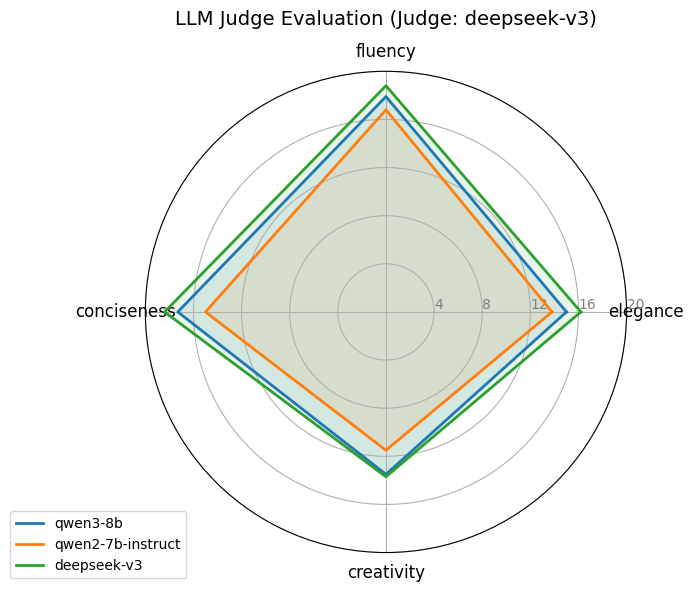

In [10]:
plot_model_comparison_radar(
    model_names=model_names,
    judge_model=judge_model
)

## 4.3 Bias1: Same family models

The researchers found that llm as judge had very some problems, such as the model with lower ability sometimes cannot be a good judge, and the model's tendency to give higher scores to the answers of its own or model from same 'famliy'. We will discuss and investigate this in this section.

10it [00:01,  6.46it/s]
Judging qwen2.5-72b-instruct: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it]



qwen2.5-72b-instruct average scores (judged by qwen2.5-7b-instruct):
  elegance    : 16.70
  fluency     : 19.00
  conciseness : 18.10
  creativity  : 16.10

Results saved to judge_results/qwen2.5-72b-instruct_evaluations_qwen2.5-7b-instruct.jsonl


10it [00:02,  4.97it/s]
Judging llama-3.3-70b-instruct: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]



llama-3.3-70b-instruct average scores (judged by qwen2.5-7b-instruct):
  elegance    : 15.20
  fluency     : 18.50
  conciseness : 17.20
  creativity  : 13.80

Results saved to judge_results/llama-3.3-70b-instruct_evaluations_qwen2.5-7b-instruct.jsonl


10it [00:02,  4.35it/s]
Judging deepseek-v3: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]



deepseek-v3 average scores (judged by qwen2.5-7b-instruct):
  elegance    : 15.70
  fluency     : 18.80
  conciseness : 17.50
  creativity  : 14.80

Results saved to judge_results/deepseek-v3_evaluations_qwen2.5-7b-instruct.jsonl


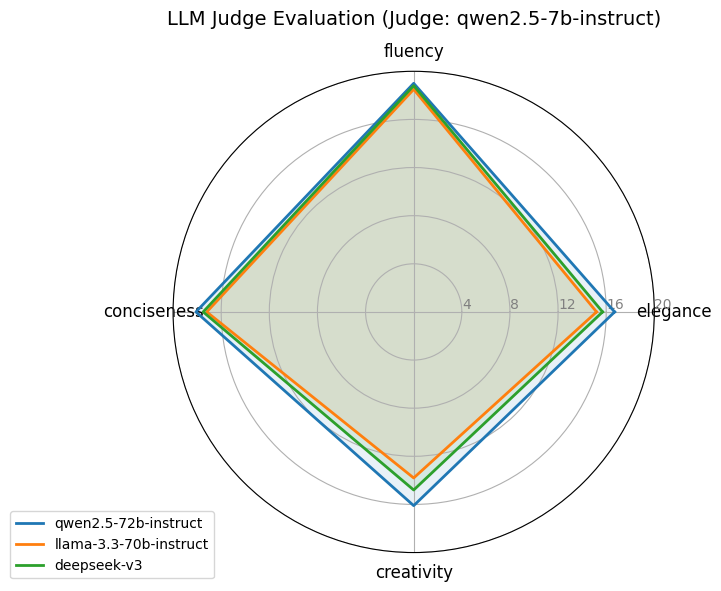

In [11]:
# let's test model's bias here
# let's first use qwen2.5 model as judge
judge_model = "qwen2.5-7b-instruct"
model_names = ["qwen2.5-72b-instruct", "llama-3.3-70b-instruct", "deepseek-v3"]
for model_name in model_names:
    evaluate_model(judge_model, model_name, d, evaluate_n)

plot_model_comparison_radar(
    model_names=model_names,
    judge_model=judge_model
)


# What will happen if we choose the range of socre to be 1-5. 1-10. 1-100?
# Let's test it here

0it [00:00, ?it/s]

10it [00:01,  7.13it/s]
Judging qwen2.5-72b-instruct: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]



qwen2.5-72b-instruct average scores (judged by deepseek-v3):
  elegance    : 14.10
  fluency     : 17.50
  conciseness : 16.20
  creativity  : 11.90

Results saved to judge_results/qwen2.5-72b-instruct_evaluations_deepseek-v3.jsonl


10it [00:02,  4.95it/s]
Judging llama-3.3-70b-instruct: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]



llama-3.3-70b-instruct average scores (judged by deepseek-v3):
  elegance    : 13.20
  fluency     : 16.80
  conciseness : 18.20
  creativity  : 10.40

Results saved to judge_results/llama-3.3-70b-instruct_evaluations_deepseek-v3.jsonl


10it [00:02,  4.43it/s]
Judging deepseek-v3: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]



deepseek-v3 average scores (judged by deepseek-v3):
  elegance    : 16.20
  fluency     : 19.00
  conciseness : 18.60
  creativity  : 13.40

Results saved to judge_results/deepseek-v3_evaluations_deepseek-v3.jsonl


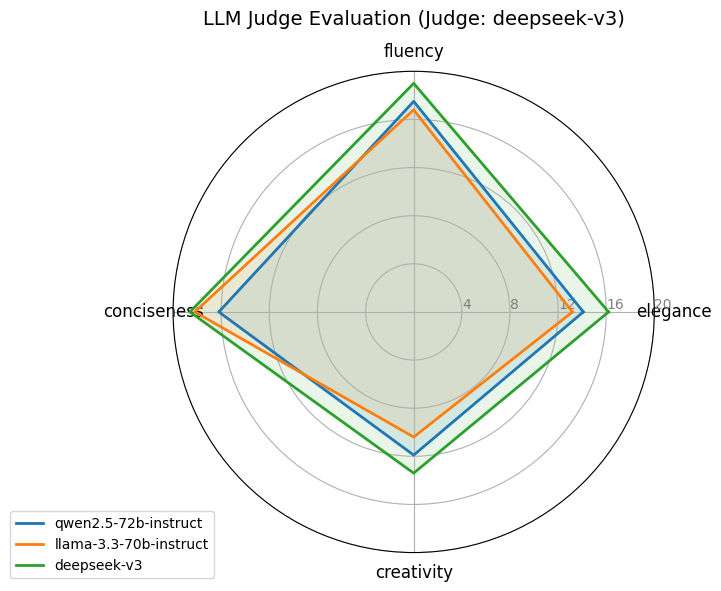

In [12]:
judge_model = "deepseek-v3"
# using the same models as before
for model_name in model_names:
    evaluate_model(judge_model, model_name, d, evaluate_n)


plot_model_comparison_radar(
    model_names=model_names,
    judge_model=judge_model
)

## 4.4 Pairwise Comparison judge, and Bias2: positions.

Another problem is llm's judgement is depend on position.

In [16]:
# here is the prompt for pairwise comparison judge
def compare_model_summaries(model1_name, model2_name, judge_model, num_samples):
    """
    Compare summaries from two different models using a judge model.
    """
    import json, os, random
    from tqdm import tqdm

    model1_file = f"judge_results/{model1_name}_evaluations_{judge_model}.jsonl"
    model2_file = f"judge_results/{model2_name}_evaluations_{judge_model}.jsonl"

    with open(model1_file, "r") as f:
        model1_data = [json.loads(l) for l in f]

    with open(model2_file, "r") as f:
        model2_data = [json.loads(l) for l in f]

    common_ids = list(
        {d["article_id"] for d in model1_data}.intersection(
            {d["article_id"] for d in model2_data}
        )
    )
    if len(common_ids) < num_samples:
        print(f"Warning: only {len(common_ids)} common articles, using all.")
        num_samples = len(common_ids)

    selected_ids = random.sample(common_ids, num_samples)
    m1 = {d["article_id"]: d for d in model1_data}
    m2 = {d["article_id"]: d for d in model2_data}

    wins = {model1_name: 0, model2_name: 0, "tie": 0}

    for aid in tqdm(selected_ids, desc=f"{model1_name} vs {model2_name}"):
        art = m1[aid]["article"]
        ref = m1[aid]["reference"]
        s1  = m1[aid]["model_answer"]
        s2  = m2[aid]["model_answer"]

        prompt = f"""You are an expert judge evaluating two summaries of a news article.

Article: {art}

Reference Summary: {ref}

Summary A: {s1}

Summary B: {s2}

Compare the two summaries on elegance, fluency, conciseness, and creativity.
Which summary is better overall? Respond with **only** "A", "B", or "Tie" on the first line,
then optionally give a short explanation on the next line.
"""

        resp = client.chat.completions.create(
            model=judge_model,
            messages=[{"role": "user", "content": prompt}],
        )

        judge_text = resp.choices[0].message.content.strip()
        first_line = judge_text.splitlines()[0].strip().upper()

        if first_line.startswith("A"):
            wins[model1_name] += 1
        elif first_line.startswith("B"):
            wins[model2_name] += 1
        else:
            wins["tie"] += 1

    print(f"\nResults ({judge_model} as judge)")
    print(f"{model1_name} wins: {wins[model1_name]}")
    print(f"{model2_name} wins: {wins[model2_name]}")
    print(f"Ties: {wins['tie']}")
    return wins

In [19]:
compare_results = compare_model_summaries(
    "qwen2.5-72b-instruct", 
    "llama-3.3-70b-instruct", 
    "deepseek-v3", 
    evaluate_n
)

compare_results = compare_model_summaries(
    "llama-3.3-70b-instruct",
    "qwen2.5-72b-instruct", 
    "deepseek-v3", 
    evaluate_n
)

qwen2.5-72b-instruct vs llama-3.3-70b-instruct: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]



Results (deepseek-v3 as judge)
qwen2.5-72b-instruct wins: 10
llama-3.3-70b-instruct wins: 0
Ties: 0


llama-3.3-70b-instruct vs qwen2.5-72b-instruct: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Results (deepseek-v3 as judge)
llama-3.3-70b-instruct wins: 0
qwen2.5-72b-instruct wins: 10
Ties: 0


In [20]:
compare_results = compare_model_summaries(
    "qwen2.5-72b-instruct", 
    "llama-3.3-70b-instruct", 
    "qwen2.5-7b-instruct", 
    evaluate_n
)

compare_results = compare_model_summaries(
    "llama-3.3-70b-instruct",
    "qwen2.5-72b-instruct", 
    "qwen2.5-7b-instruct", 
    evaluate_n
)

qwen2.5-72b-instruct vs llama-3.3-70b-instruct:   0%|          | 0/10 [00:00<?, ?it/s]

qwen2.5-72b-instruct vs llama-3.3-70b-instruct: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]



Results (qwen2.5-7b-instruct as judge)
qwen2.5-72b-instruct wins: 6
llama-3.3-70b-instruct wins: 4
Ties: 0


llama-3.3-70b-instruct vs qwen2.5-72b-instruct: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Results (qwen2.5-7b-instruct as judge)
llama-3.3-70b-instruct wins: 2
qwen2.5-72b-instruct wins: 8
Ties: 0


See the differences?

## 4.5 Further Questions about LLM-as-Judge

There are several interesting questions about using LLMs as judges that you might want to explore:

1. **Judge Bias**: Does the choice of judge model significantly impact the results? 

2. **Prompt Sensitivity**: How sensitive are the judgments to the specific wording of the prompt? 

3. **Consistency**: How consistent are LLM judges across multiple evaluations of the same content? 

4. **Ability Limitation**: How do models perform when judging the tasks they cannot achieve perfectly?

5. **Correlation with Human Judgment**: How well do LLM judgments align with human preferences? 

6. **Metric Weighting**: Do certain metrics (like fluency or creativity) have more influence on the overall judgment than others?



In [ ]:
#### your task ####
# find a dataset that you are interested in, and use llm-as-judge to evaluate the model.
# plot the radar graph of the results (with dimensions of your choice, but as least 4 dimensions)
# you should find two models with as much performance difference as possible.
# to do so, you need choose a good evaluation set, as well as a good judge model.

In [10]:
d = load_dataset('json', data_files='/ssdshare/share/lkh/PHYBench/PHYBench-fullques_v1.json')
print(d)

DatasetDict({
    train: Dataset({
        features: ['content', 'solution', 'tag', 'id', 'answer'],
        num_rows: 100
    })
})


In [11]:
def create_prompt(x):
    s = f"Please solve the following physics problem. Provide a detailed, step-by-step solution along with the final answer in LaTeX format.\n{x['content']}"
    x['question_content'] = s
    return x

d = d['train'].map(create_prompt)
print(d)

Dataset({
    features: ['content', 'solution', 'tag', 'id', 'answer', 'question_content'],
    num_rows: 100
})


In [13]:
# judge model

def create_judge_prompt(question, ref_solution, model_solution, model_name):
    prompt = f"""Please evaluate the following solution to a physics problem.

# Problem:
{question}

# Reference Solution:
{ref_solution}

# Model ({model_name}) Solution:
{model_solution}

Please rate the model's solution on the following dimensions on a scale of 0-20 (0 being the worst one, 20 being the perfect one):
1. Correctness: Comparing to the reference solution (which is 20 points), how correct is the model's solution?
2. Clarity: Comparing to the reference solution (which is 15 points), how clear is the model's solution?
3. Logical Flow: Comparing to the reference solution (which is 15 points), how logical is the model's solution?
4. Efficiency: Comparing to the reference solution (which is 15 points), how efficient is the model's solution?

For each dimension, provide a score and a short explanation (less than 20 words, plain text, NO LaTeX equations). Format your response as follows:
{{
  "correctness": {{
    "score": <score>,
    "explanation": "<explanation>"
  }},
  "clarity": {{
    "score": <score>,
    "explanation": "<explanation>"
  }},
  "logical flow": {{
    "score": <score>,
    "explanation": "<explanation>"
  }},
  "efficiency": {{
    "score": <score>,
    "explanation": "<explanation>"
  }}
}}
"""
    return prompt

def parse_judge_output(judge_output):
    try:
        match = re.search(r"\{.*\}", judge_output, re.DOTALL)
        if not match:
            raise ValueError("No JSON object found in the output.")
        
        json_str = match.group(0)
        json_str = re.sub(r'("explanation"\s*:\s*"[^"]+)"\s*(")', r'\1,\2', json_str)
        json_str = json_str.strip()

        return json.loads(json_str)

    except Exception as e:
        print(f"Error parsing judge output: {e}")
        print(f"Raw output: {judge_output}")
        return {
            "correctness": {"score": 10, "explanation": "Failed to parse"},
            "clarity": {"score": 10, "explanation": "Failed to parse"},
            "logical flow": {"score": 10, "explanation": "Failed to parse"},
            "efficiency": {"score": 10, "explanation": "Failed to parse"}
        }
    
output_dir = "PHYBench_results"
os.makedirs(output_dir, exist_ok=True)

In [14]:
import os
import json
from tqdm import tqdm

def evaluate_model(
    judge_model: str,
    model_name: str,
    dataset: dict,
    evaluate_n: int = 10,
    output_dir: str = output_dir,
    model_threads: int = 5,
) -> dict:


    # 1. take a subset of the dataset
    content    = dataset['content'][:evaluate_n]
    questions  = dataset['question_content'][:evaluate_n]
    references = dataset['solution'][:evaluate_n]

    # 2. ask the model to generate answers
    model_answers = get_llm_output_parallel(
        model_name, questions, max_threads=model_threads
    )

    results = []

    # 3. generate a score using the judge model
    for i in tqdm(range(evaluate_n), desc=f"Judging {model_name}"):
        judge_prompt  = create_judge_prompt(
            content[i], references[i], model_answers[i], model_name
        )
        judge_response = get_llm_output_parallel(
            judge_model, [judge_prompt], max_threads=1
        )[0]

        scores = parse_judge_output(judge_response)

        results.append({
            "problem_id"  : dataset['id'][i],
            "problem"     : content[i],
            "reference"   : references[i],
            "model_answer": model_answers[i],
            "scores"      : scores
        })

    # 4. save the results to a file
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(
        output_dir, f"{model_name}_evaluations_{judge_model}.jsonl"
    )
    with open(output_file, "w", encoding="utf-8") as f:
        for r in results:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

    # 5. compute the average scores
    dims = ["correctness", "clarity", "logical flow", "efficiency"]
    avg_scores = {d: sum(r["scores"][d]["score"] for r in results) / evaluate_n
                  for d in dims}

    # 6. print the results (optional)
    print(f"\n{model_name} average scores (judged by {judge_model}):")
    for d, s in avg_scores.items():
        print(f"  {d:<12}: {s:.2f}")
    print(f"\nResults saved to {output_file}")

    return {
        "output_file": output_file,
        "avg_scores" : avg_scores,
    }

In [52]:
evaluate_n = 10

judge_model = 'deepseek-v3'

model_names = ['deepseek-v3', 'qwen2-7b-instruct']

for model_name in model_names:
    evaluate_model(judge_model, model_name, d, evaluate_n)

10it [01:03,  6.36s/it]
Judging deepseek-v3: 100%|██████████| 10/10 [00:52<00:00,  5.20s/it]



deepseek-v3 average scores (judged by deepseek-v3):
  correctness : 15.20
  clarity     : 16.00
  logical flow: 16.10
  efficiency  : 14.20

Results saved to PHYBench_results/deepseek-v3_evaluations_deepseek-v3.jsonl


10it [00:16,  1.67s/it]
Judging qwen2-7b-instruct: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


qwen2-7b-instruct average scores (judged by deepseek-v3):
  correctness : 5.50
  clarity     : 10.60
  logical flow: 8.60
  efficiency  : 7.10

Results saved to PHYBench_results/qwen2-7b-instruct_evaluations_deepseek-v3.jsonl


In [14]:
import os, json, numpy as np
import matplotlib.pyplot as plt

# utility function to plot the results
def plot_model_comparison_radar(model_names, judge_model, output_dir=output_dir):

    all_avg_scores = {}
    for model_name in model_names:
        path = os.path.join(output_dir,
                            f"{model_name}_evaluations_{judge_model}.jsonl")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Result file not found: {path}")
        
        with open(path, "r", encoding="utf-8") as f:
            results = [json.loads(line) for line in f]
        
        # Initialize the dimensions
        dims = ["correctness", "clarity", "logical flow", "efficiency"]
        avg = {d: 0.0 for d in dims}
        for r in results:
            for d in dims:
                avg[d] += r["scores"][d]["score"]
        for d in dims:
            avg[d] /= len(results)
        all_avg_scores[model_name] = avg
    
    dimensions = list(next(iter(all_avg_scores.values())).keys())
    N = len(dimensions)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # close the circle
    
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    
    plt.xticks(angles[:-1], dimensions, size=12)
    
    ax.set_rlabel_position(0)
    plt.yticks([4, 8, 12, 16, 20], ["4", "8", "12", "16", "20"], color="grey", size=10)
    plt.ylim(0, 20)
    
    for model_name in model_names:
        vals = [all_avg_scores[model_name][d] for d in dimensions]
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, vals, alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(f"LLM Judge Evaluation (Judge: {judge_model})", size=14, y=1.08)
    plt.tight_layout()
    plt.show()


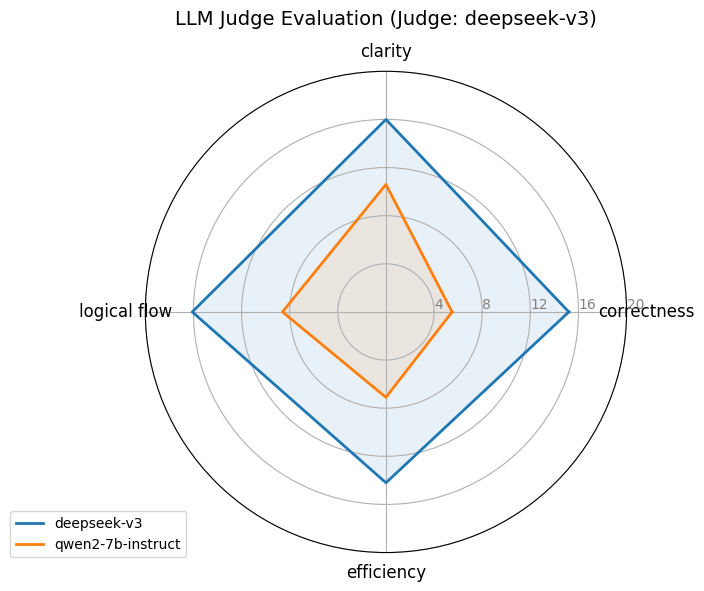

In [54]:
plot_model_comparison_radar(
    model_names=model_names,
    judge_model=judge_model
)

# Bonus: Study the Consistency of LLM as Judge

In [15]:
# Evaluate the variance of the scores

output_dir = "consistency_results"

def evaluate_model(
    judge_model: str,
    model_name: str,
    dataset: dict,
    evaluate_n: int = 10,
    output_dir: str = output_dir,
    model_threads: int = 5,
    repeat: int = 3,
) -> dict:
    
    content   = dataset['content'][:evaluate_n]
    questions = dataset['question_content'][:evaluate_n]
    references = dataset['solution'][:evaluate_n]

    model_answers = get_llm_output_parallel(
        model_name, questions, max_threads=model_threads
    )

    results = {
        'correctness': [],
        'clarity': [],
        'logical flow': [],
        'efficiency': [],
    }

    for i in tqdm(range(evaluate_n), desc=f"Judging {model_name}"):
        judge_prompt  = create_judge_prompt(
            content[i], references[i], model_answers[i], model_name
        )
        for _ in range(repeat):
            judge_response = get_llm_output_parallel(
                judge_model, [judge_prompt], max_threads=1
            )[0]

            scores = parse_judge_output(judge_response)

            for k in results.keys():
                results[k].append(scores[k]['score'])

    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(
        output_dir, f"{model_name}_evaluations_{judge_model}.json"
    )
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(json.dumps(results, ensure_ascii=False) + "\n")

    for k in results.keys():
        std = []
        for i in range(0, len(results[k]), repeat):
            std.append(np.std(results[k][i:i+repeat]))
        print(f"{k} std: {np.mean(std):.2f}") 

In [16]:
evaluate_n = 10
judge_model = 'deepseek-v3'
model_name = 'qwen2.5-7b-instruct'

evaluate_model(judge_model, model_name, d, evaluate_n)

10it [00:16,  1.60s/it]
1it [00:00, 178.67it/s]ruct:   0%|          | 0/10 [00:00<?, ?it/s]
1it [00:00, 157.04it/s]
1it [00:00, 163.62it/s]
1it [00:00, 139.10it/s]ruct:  10%|█         | 1/10 [00:12<01:50, 12.33s/it]
1it [00:00, 140.49it/s]
1it [00:00, 180.48it/s]
1it [00:00, 219.32it/s]ruct:  20%|██        | 2/10 [00:26<01:49, 13.68s/it]
1it [00:00, 152.56it/s]
1it [00:00, 182.39it/s]
1it [00:00, 186.58it/s]ruct:  30%|███       | 3/10 [00:44<01:47, 15.30s/it]
1it [00:00, 181.09it/s]
1it [00:00, 162.76it/s]
1it [00:00, 149.97it/s]ruct:  40%|████      | 4/10 [01:00<01:34, 15.68s/it]
1it [00:00, 190.06it/s]
1it [00:00, 170.49it/s]
1it [00:00, 152.56it/s]ruct:  50%|█████     | 5/10 [01:15<01:17, 15.44s/it]
1it [00:00, 207.01it/s]
1it [00:00, 137.23it/s]
1it [00:00, 210.10it/s]ruct:  60%|██████    | 6/10 [01:26<00:55, 13.95s/it]
1it [00:00, 196.53it/s]
1it [00:00, 195.40it/s]
1it [00:00, 153.50it/s]ruct:  70%|███████   | 7/10 [01:46<00:47, 15.92s/it]
1it [00:00, 162.98it/s]
1it [00:00, 181.

correctness std: 0.71
clarity std: 0.44
logical flow std: 0.67
efficiency std: 0.70


In [18]:
# Plot bar graph of the variance
def plot_variance_graph(model_name, judge_model, repeat=3, output_dir=output_dir):
    with open(os.path.join(output_dir, f"{model_name}_evaluations_{judge_model}.json"), "r") as f:
        results = json.load(f)
    dimensions = list(results.keys())
    variances = []
    for k in dimensions:
        std = []
        for i in range(0, len(results[k]), repeat):
            std.append(np.std(results[k][i:i+repeat]))
        variances.append(np.mean(std))
    plt.bar(dimensions, variances)
    plt.xlabel("Dimensions")
    plt.ylabel("Variance")
    plt.title(f"Variance of Scores for {model_name} (Judge: {judge_model})")
    plt.ylim(0, 1)
    plt.show()

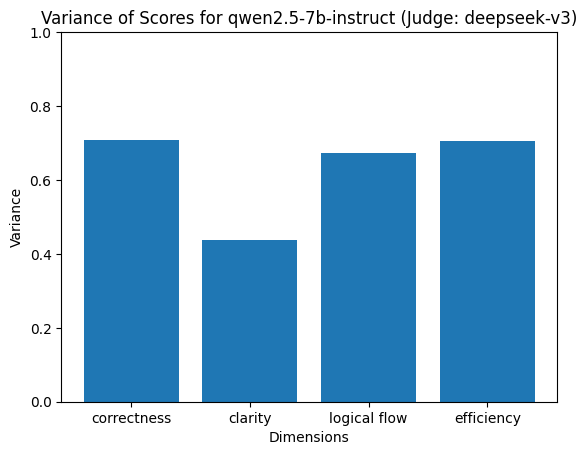

In [19]:
plot_variance_graph(
    model_name=model_name,
    judge_model=judge_model
)

## Explanation

The variances of all dimensions are less than 0.8, which means the model is quite consistent in judging the same answer.